# Introduction
This notebook is a personal project. The goal is to accurately forecast indoor/supply temperatures based on other variables such as external temperature, exhaust temperature,recirculation temperature and humidity. I aim to practise my feature engineering, data visualization and basic modelling.

In [1]:
import pandas as pd
import numpy as np
import glob
import time

import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

from functools import reduce
from scipy import stats

In [2]:
path = r"C:\Users\Roy\Desktop\ForecastTemperature"

def read_ahu_one():

    ahu_one = "\AHU1\\"

    exh = pd.read_csv(path + ahu_one + "ahu1_evac.csv")
    ext = pd.read_csv(path + ahu_one + "ahu1_ext.csv")
    hum = pd.read_csv(path + ahu_one + "ahu1_hum.csv")
    sup = pd.read_csv(path + ahu_one + "ahu1_in.csv")
    rec = pd.read_csv(path + ahu_one + "ahu1_rec.csv")

    exh.columns = ['date', 'exh'] # Exhaust temperature
    ext.columns = ['date', 'ext'] # Outdoor temperature
    hum.columns = ['date', 'hum'] # Humidity
    sup.columns = ['date', 'sup'] # Supply temperature
    rec.columns = ['date', 'rec'] # Recirculation temperature

    return exh, ext, hum, sup, rec

evac, ext, hum, sup, rec = read_ahu_one()

def MergeData():

    list_of_data = [evac, ext, hum, sup, rec]

    data = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), list_of_data)

    # Reorder columns.
    data = data[['date', 'exh', 'ext', 'hum', 'rec', 'sup']]

    return data

data = MergeData()

def PrepareData():

    evac, ext, hum, sup, rec = read_ahu_one()

    data = MergeData()

    return data

data = PrepareData()

In [3]:
def GenerateProfile(data, title_name, title_output):

    profile = ProfileReport(data, title=title_name)
    profile.to_file(output_file=title_output)

def CorrelationMap():
    
    print(data.columns)

    DC = data.iloc[:, 1:5]
    CRLN = DC.corr()

    f, ax = plt.subplots(figsize=(17, 14))
    sns.heatmap(CRLN, annot=True, fmt=".2f")
    plt.xticks(range(len(CRLN.columns)), CRLN.columns)
    plt.yticks(range(len(CRLN.columns)), CRLN.columns)
    plt.show()


In [4]:
# def RemoveOutlierZ(data):

#     data['z'] = np.abs(stats.zscore(data['sup']))

#     print("\nHighest z-score is " + str(data['z'].max()))

#     print("\nData shape before outlier removal: " + str(data.shape))
#     data = data[data.z < 3]
#     print("Data shape after outlier removal: " + str(dat.shape))
#     z = np.abs(stats.zscore(data['sup']))
#     print("\nHighest z-score is now " + str(data['z'].max()))

In [5]:
def CalculateEnergy(data):
    """Calculates the energy necessary to
    attain a certain temperature."""

    # Creates two new columns: energy and sup_diff.
    # Energy will be calculated using specific heat.
    # Sup_diff calculates the difference in supply air temp.
    data['energy'] = None
    data['energy'] = pd.to_numeric(data['energy'], downcast='integer')
    data['sup_diff'] = data['sup'].diff()
    data['sup_diff'][0] = "34.6"

    # The approximate density of air (room temperature) is 1.292 per cubic meter (m3).
    # The cubic meter per hour in Cabin J14 is 439 m3/h.
    mass = (1.292 * 439) # Kilograms.
    specific_heat = 1012 # Joule.

    start = time.time()

    for row in data.itertuples():

        # Calculates the energy required to heat up a room.
        data['energy'] = (mass * specific_heat * data['sup_diff']).round(decimals=2)
        data['kwh'] = (data['energy'] * 0.0000002778)
        
        # Fills up zero values with the average value.
        data['energy'] = data['energy'].replace(to_replace=0, value=data['energy'].mean())

    print(data.head(n=15))

    # Sums up J and converts it to kWh.
    JouleSum = data['energy'].where(data['energy'] > 0).sum()
    kWhSum = (JouleSum * 0.0000002778)
    
    print("\nTotal energy use is {0:,.2f} in Joules.".format(JouleSum))
    print("This is {0:,.2f} in kWh.".format(kWhSum))

    stop = time.time()
    c_time = stop - start

    print("This computation took " + str((c_time / 60)) + " minutes.")

    return data

data = CalculateEnergy(data)

                        date   exh  ext   hum   rec   sup        energy  \
0   06-Jan-17 5:15:00 PM EET  27.2 -2.5  50.0  10.6  34.6  1.986020e+07   
1   06-Jan-17 5:20:00 PM EET  27.2 -2.5  50.0  10.6  34.7  5.739943e+04   
2   06-Jan-17 5:25:00 PM EET  27.2 -2.5  50.0  10.6  34.2 -2.869971e+05   
3   06-Jan-17 5:30:00 PM EET  27.2 -3.0  50.0  10.6  34.7  2.869971e+05   
4   06-Jan-17 5:35:00 PM EET  27.2 -3.5  50.0  10.6  34.2 -2.869971e+05   
5   06-Jan-17 5:40:00 PM EET  27.2 -3.5  50.0  10.1  34.2  1.599319e+02   
6   06-Jan-17 5:45:00 PM EET  27.2 -3.5  50.0  10.1  34.2  1.599319e+02   
7   06-Jan-17 5:50:00 PM EET  27.2 -3.5  50.0  10.1  34.2  1.599319e+02   
8   06-Jan-17 5:55:00 PM EET  27.2 -3.5  50.0  10.1  34.7  2.869971e+05   
9   06-Jan-17 6:00:00 PM EET  27.2 -4.0  50.0  10.1  34.7  1.599319e+02   
10  06-Jan-17 6:05:00 PM EET  27.2 -4.0  50.0  10.1  34.7  1.599319e+02   
11  06-Jan-17 6:10:00 PM EET  27.2 -3.5  50.0  10.1  34.7  1.599319e+02   
12  06-Jan-17 6:15:00 PM 

In [6]:
# Creating copy of the dataframe.
data_copy = pd.DataFrame.copy(data, deep=True)

## Feature Engineering

To optimise our model with additional variables for input, I calculate both the hourly running mean outdoor and indoor temperature, as well as the humidity. Aguilera et al. concluded that due to the thermal mass of a building, the outdoor air temperature does not have an instant effect on the air temperature indoors, which explains the importance of TRM as an input parameter to estimate TA. 

The hourly mean features are estimated based on the values within that particular hour that is otherwised measured at a five minute interval. I'm using the forward fill function as a safety measure, as the model will iterate over the values in each row. I have not tested the efficiency of also computing the hourly mean humidity, however tests will be done later to benchmark the performance and added value.

In [7]:
def CalculateRMT(data):
    """This function calculates the
    hourly running mean outdoor and 
    indoor temperatures and humidity."""
    
    data = data.set_index('date')
    data.index = pd.to_datetime(data.index, utc=True)

    # Resamples each variable into an hourly mean.
    hourly_mean_outside = data['ext'].resample('H').mean()
    hourly_mean_supply = data['sup'].resample('H').mean()
    hourly_mean_humidity = data['hum'].resample('H').mean()

    # Appends variables as fresh columns.
    data['rmot'] = hourly_mean_outside
    data['rmit'] = hourly_mean_supply
    data['rmoh'] = hourly_mean_humidity

    columns = ['rmot', 'rmit', 'rmoh']

    data[columns] = data[columns].fillna(method='ffill')
    data[columns] = data[columns].fillna(method='bfill')
    data[columns] = data[columns].round(decimals=2)
    
    print(data.head(n=10))

    return data

data = CalculateRMT(data)

                            exh  ext   hum   rec   sup        energy  \
date                                                                   
2017-01-06 17:15:00+00:00  27.2 -2.5  50.0  10.6  34.6  1.986020e+07   
2017-01-06 17:20:00+00:00  27.2 -2.5  50.0  10.6  34.7  5.739943e+04   
2017-01-06 17:25:00+00:00  27.2 -2.5  50.0  10.6  34.2 -2.869971e+05   
2017-01-06 17:30:00+00:00  27.2 -3.0  50.0  10.6  34.7  2.869971e+05   
2017-01-06 17:35:00+00:00  27.2 -3.5  50.0  10.6  34.2 -2.869971e+05   
2017-01-06 17:40:00+00:00  27.2 -3.5  50.0  10.1  34.2  1.599319e+02   
2017-01-06 17:45:00+00:00  27.2 -3.5  50.0  10.1  34.2  1.599319e+02   
2017-01-06 17:50:00+00:00  27.2 -3.5  50.0  10.1  34.2  1.599319e+02   
2017-01-06 17:55:00+00:00  27.2 -3.5  50.0  10.1  34.7  2.869971e+05   
2017-01-06 18:00:00+00:00  27.2 -4.0  50.0  10.1  34.7  1.599319e+02   

                           sup_diff       kwh  rmot  rmit  rmoh  
date                                                             
201

In [8]:
def Interpolate(data):
    """Fills up more 0 values."""

    columns = ['exh', 'ext', 'hum', 'rec',
               'sup', 'rmot', 'rmit', 'rmoh']

    data[columns] = data[columns].replace(to_replace=0, value=data[columns].mean())
    data[columns] = data[columns].round(decimals=2)

    return data

datA = Interpolate(data)    

In [9]:
data = pd.DataFrame.copy(datA, deep=True)

In [10]:
def RemoveOutlierZ(data):

    data['z'] = np.abs(stats.zscore(data['sup']))

    print("\nHighest z-score is " + str(data['z'].max()))

    print("\nData shape before outlier removal: " + str(data.shape))
    data = data[data.z < 2.5]
    print("Data shape after outlier removal: " + str(data.shape))
    z = np.abs(stats.zscore(data['sup']))
    print("\nHighest z-score is now " + str(data['z'].max()))

    return data

data = RemoveOutlierZ(data)
data_v2 = pd.DataFrame.copy(data, deep=True)


Highest z-score is 4.595157665692344

Data shape before outlier removal: (103004, 12)
Data shape after outlier removal: (100278, 12)

Highest z-score is now 2.4949638670015575


In [11]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [12]:
from sklearn.model_selection import GridSearchCV

def FindParameters():
    """Finds out the optimal parameters
    for the neural network.""" 

    mlp = MLPRegressor(max_iter=100)

    parameter_space = {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive']
        }

    rgr = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
    rgr.fit(train_x, train_y)

    print('Best parameters found:\n', rgr.best_params_)

    nn_params = rgr.best_params_

    return nn_params

# nn_params = FindParameters()

In [13]:
from sklearn.preprocessing import MinMaxScaler

df = pd.DataFrame.copy(data_v2, deep=True)
df = df.reset_index()

def SplitData(x):
    """Splits up the data in
    train and test data based on
    date time ranges."""

    sc = MinMaxScaler()

    train_x = df[0:76588].drop(columns=['date', 'sup', 'energy', 'sup_diff', 'kwh'])
    train_y = df[0:76588].filter(['sup'])
    #train_x = sc.fit_transform(train_x)
    #train_y = sc.fit_transform(train_y)

    test_x = df[76589:].drop(columns=['date', 'sup', 'energy', 'sup_diff', 'kwh'])
    test_y = df[76589:].filter(['sup'])
    #test_x = sc.fit_transform(test_x)
    #test_y = sc.fit_transform(test_y)


    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = SplitData(df)

The true model's RMSE amounts to 0.23051
The training model's RMSE amounts to 0.21376


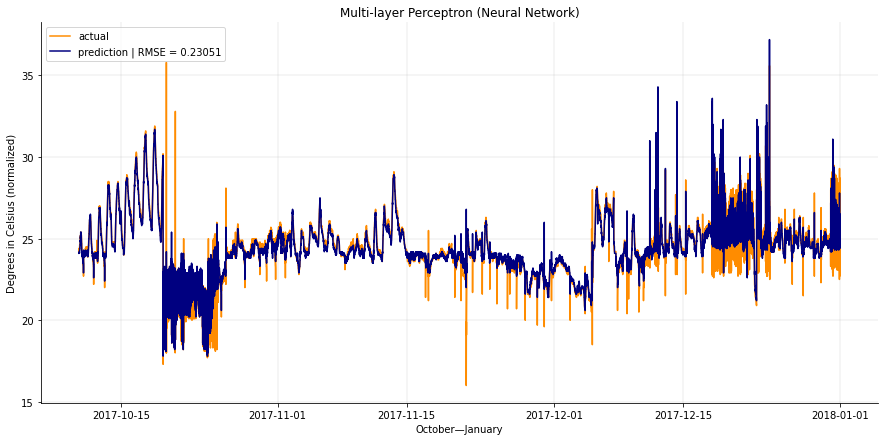

In [14]:
def MLP_NN(train_x, train_y, test_x, test_y):
    """Initializes the neural network model."""

    mlp = MLPRegressor(activation='relu', alpha=0.0001, 
                       hidden_layer_sizes=(50, 50, 50), 
                       learning_rate='constant', solver='adam', 
                       random_state=22)

    mlp.fit(train_x, train_y)
    nn_pred = mlp.predict(test_x)

    # Creates a dataframe with actual & predicted values.
    # Computes the RMSE of the MLP model.
    comparison = pd.DataFrame(test_y, nn_pred)
    comparison.columns = comparison.columns=['prediction']
    mlp_mse = mean_squared_error(test_y, nn_pred).round(decimals=5)

    # Predicts the train data.
    act_pred = mlp.predict(train_x)
    comparison = pd.DataFrame(train_y, act_pred)
    comparison.columns = comparison.columns=['prediction']
    act_mse = mean_squared_error(train_y, act_pred).round(decimals=5)

    nn_results = df[76589:].filter(['date'])
    nn_results['actual'] = test_y
    nn_results['prediction'] = nn_pred.round(decimals=1)

    fig, ax = plt.subplots(figsize=(15, 7))
    sns.lineplot(x='date', y='actual', data=nn_results, color='darkorange', ax=ax).set_title('Multi-layer Perceptron (Neural Network)')
    sns.lineplot(x='date', y='prediction', data=nn_results, color='navy', ax=ax)

    ax.legend(['actual', 'prediction | RMSE = ' + str(mlp_mse)])
    plt.xlabel('October—January')
    plt.ylabel('Degrees in Celsius (normalized)')

    plt.grid(linewidth=0.25)
    sns.despine()

    print("The true model's RMSE amounts to " + str(mlp_mse))
    print("The training model's RMSE amounts to " + str(act_mse))

    return nn_results, mlp_mse, act_mse

nn_results, mlp_mse, act_mse = MLP_NN(train_x, train_y, test_x, test_y)

In [15]:
def CalcEnergy(data):
    """Same function as before but modified
    to calculate new energy as well."""

    data['actual_energy'] = None
    data['predicted_energy'] = None

    data['actual_energy'] = pd.to_numeric(data['actual_energy'], downcast='integer')
    data['predicted_energy'] = pd.to_numeric(data['predicted_energy'], downcast='integer')

    data['act_sup_diff'] = data['actual'].diff()
    data['pred_sup_diff'] = data['prediction'].diff()

    mass = (1.292 * 439)
    specific_heat = 1012 

    for row in data.itertuples():

        data['actual_energy'] = (mass * specific_heat * data['act_sup_diff']).round(decimals=2)
        data['predicted_energy'] = (mass * specific_heat * data['pred_sup_diff']).round(decimals=2)

        data['actual_energy'] = data['actual_energy'].replace(to_replace=0, value=data['actual_energy'].mean())
        data['predicted_energy'] = data['predicted_energy'].replace(to_replace=0, value=data['predicted_energy'].mean())

    actual_joule = data['actual_energy'].where(data['actual_energy'] > 0).sum()
    predicted_joule = data['predicted_energy'].where(data['predicted_energy'] > 0).sum()

    actual_kwh = (actual_joule * 0.0000002778)
    predicted_kwh = (predicted_joule * 0.0000002778)

    print("Actual kWh is {0:,.2f}".format(actual_kwh))
    print("Predicted kWh is {0:,.2f}".format(predicted_kwh))

    return actual_kwh, predicted_kwh

In [16]:
nn_results['prediction'] = nn_results['prediction'].round(decimals=2)

nn_results.columns
actual_kwh, predicted_kwh = CalcEnergy(nn_results)

Actual kWh is 480.93
Predicted kWh is 386.16


In [29]:
df = pd.DataFrame.copy(data_v2, deep=True)
df = df.reset_index()

df.to_csv('df.csv')

def SplitNovData(df):
    """Splits up the data in
    train and test data from
    a six week period."""

    train_x = df[0:88665].drop(columns=['date', 'sup', 'energy', 'sup_diff', 'kwh'])
    train_y = df[0:88665].filter(['sup'])

    test_x = df[88733:90928].drop(columns=['date', 'sup', 'energy', 'sup_diff', 'kwh'])
    test_y = df[88733:90928].filter(['sup'])

    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = SplitNovData(df)

The test model's RMSE amounts to 0.03156
The training model's RMSE amounts to 0.21451


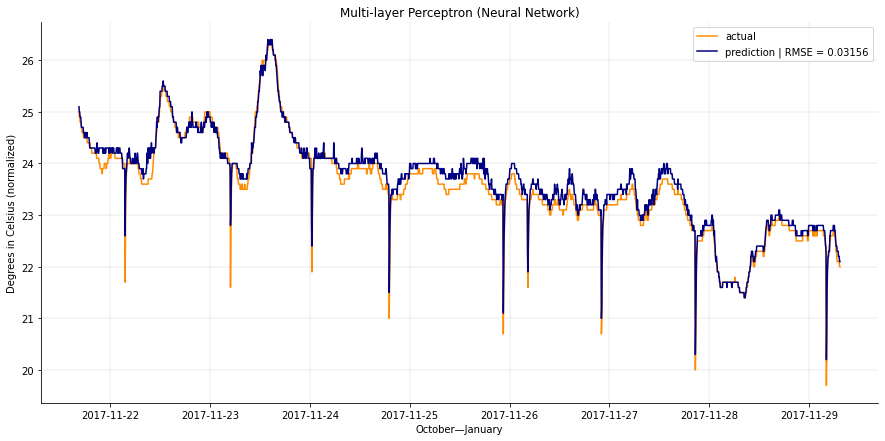

In [18]:
def MLP_NN_NOV(train_x, train_y, test_x, test_y):
    """Initializes the neural network
    for the 6-week data period."""

    mlp = MLPRegressor(activation='relu', alpha=0.0001, 
                       hidden_layer_sizes=(50, 50, 50), 
                       learning_rate='constant', solver='adam', 
                       random_state=22)

    mlp.fit(train_x, train_y)
    nn_pred = mlp.predict(test_x)

    # Predicts the train data.
    act_pred = mlp.predict(train_x)
    comparison = pd.DataFrame(train_y, act_pred)
    comparison.columns = comparison.columns=['prediction']
    act_mse = mean_squared_error(train_y, act_pred).round(decimals=5)

    # Creates a dataframe with actual & predicted values.
    # Computes the RMSE of the MLP model.
    comparison = pd.DataFrame(test_y, nn_pred)
    comparison.columns = comparison.columns=['prediction']
    mlp_mse = mean_squared_error(test_y, nn_pred).round(decimals=5)

    nn_results = df[88733:90928].filter(['date'])
    nn_results['actual'] = test_y
    nn_results['prediction'] = nn_pred.round(decimals=1)

    fig, ax = plt.subplots(figsize=(15, 7))
    sns.lineplot(x='date', y='actual', data=nn_results, color='darkorange', ax=ax).set_title('Multi-layer Perceptron (Neural Network)')
    sns.lineplot(x='date', y='prediction', data=nn_results, color='navy', ax=ax)

    ax.legend(['actual', 'prediction | RMSE = ' + str(mlp_mse)])
    plt.xlabel('October—January')
    plt.ylabel('Degrees in Celsius (normalized)')

    plt.grid(linewidth=0.25)
    sns.despine()

    print("The test model's RMSE amounts to " + str(mlp_mse))
    print("The training model's RMSE amounts to " + str(act_mse))

    return nn_results, mlp_mse, act_mse

nn_nov, nov_mlp_mse, nov_act_mse = MLP_NN_NOV(train_x, train_y, test_x, test_y)

In [19]:
actual_kwh, predicted_kwh = CalcEnergy(nn_nov)

Actual kWh is 6.27
Predicted kWh is 9.12
